In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

class DynamicConv2D(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, K=4, strides=1, padding='valid'):
        super(DynamicConv2D, self).__init__()
        self.K = K  # number of candidate filters
        self.out_channels = out_channels
        self.convs = [layers.Conv2D(out_channels, kernel_size, strides=strides, padding=padding)
                      for _ in range(K)]
        self.fc = layers.Dense(K)  # controller to predict the attention weights

    def call(self, x):
        batch_size = tf.shape(x)[0]
        pooled = tf.reduce_mean(x, axis=[1, 2])  # global average pooling
        attention = self.fc(pooled)  # predict attention
        attention = tf.nn.softmax(attention, axis=1)  # softmax over K filters

        outputs = []
        for i in range(self.K):
            conv_out = self.convs[i](x)  # apply i-th convolution
            weight = tf.reshape(attention[:, i], (batch_size, 1, 1, 1))  # reshape for broadcasting
            outputs.append(conv_out * weight)

        output = tf.add_n(outputs)  # sum up weighted conv outputs
        return output


In [8]:
def build_dynamic_cnn(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)

    # First DynamicConv2D layer
    x = DynamicConv2D(in_channels=3, out_channels=32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Second DynamicConv2D layer
    x = DynamicConv2D(in_channels=32, out_channels=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    # Flatten and dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

# Build and print the model
model = build_dynamic_cnn()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dynamic_conv2d_3                │ (None, 32, 32, 32)     │         3,600 │
│ (DynamicConv2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dynamic_conv2d_4                │ (None, 16, 16, 64)     │        74,116 │
│ (DynamicConv2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 603,806 (2.30 MB)

 Trainable params: 603,614 (2.30 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
pip install pydot

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pydot from https://files.pythonhosted.org/packages/b0/5f/1ebfd430df05c4f9e438dd3313c4456eab937d976f6ab8ce81a98f9fb381/pydot-3.0.4-py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
from IPython.display import Image
from tensorflow.keras.utils import plot_model

model = build_dynamic_cnn()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='./dynamic_cnn_model.png')


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [16]:
import tensorflow as tf
import time

# Step 1: Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0


# Step 3: Build Normal CNN
def build_normal_cnn():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, 3, padding='same'), layers.BatchNormalization(), layers.ReLU(),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, 3, padding='same'), layers.BatchNormalization(), layers.ReLU(),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Step 4: Build Dynamic CNN
def build_dynamic_cnn():
    inputs = layers.Input(shape=(32, 32, 3))

    x = DynamicConv2D(in_channels=3, out_channels=32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = DynamicConv2D(in_channels=32, out_channels=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

# Step 5: Compile both models
normal_cnn = build_normal_cnn()
dynamic_cnn = build_dynamic_cnn()

normal_cnn.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

dynamic_cnn.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Step 6: Train both models and time them
print("Training Normal CNN...")
start_time = time.time()
history_normal = normal_cnn.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=2)
normal_cnn_time = time.time() - start_time
print(f"Normal CNN training time: {normal_cnn_time:.2f} seconds")

print("\nTraining Dynamic CNN...")
start_time = time.time()
history_dynamic = dynamic_cnn.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=2)
dynamic_cnn_time = time.time() - start_time
print(f"Dynamic CNN training time: {dynamic_cnn_time:.2f} seconds")

# Step 7: Evaluate on Test Set
normal_test_loss, normal_test_acc = normal_cnn.evaluate(x_test, y_test, verbose=0)
dynamic_test_loss, dynamic_test_acc = dynamic_cnn.evaluate(x_test, y_test, verbose=0)

# Step 8: Print Results
print("\n=== Results ===")
print(f"Normal CNN Test Accuracy: {normal_test_acc*100:.2f}%")
print(f"Dynamic CNN Test Accuracy: {dynamic_test_acc*100:.2f}%")
print(f"Normal CNN Training Time: {normal_cnn_time:.2f} sec")
print(f"Dynamic CNN Training Time: {dynamic_cnn_time:.2f} sec")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training Normal CNN...
Epoch 1/10


I0000 00:00:1745879224.477541 1377823 service.cc:148] XLA service 0x1552fc001ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745879224.477895 1377823 service.cc:156]   StreamExecutor device (0): NVIDIA A30, Compute Capability 8.0
I0000 00:00:1745879224.477897 1377823 service.cc:156]   StreamExecutor device (1): NVIDIA A30, Compute Capability 8.0
2025-04-28 18:27:04.534200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-28 18:27:04.778176: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packa

1563/1563 - 7s - 4ms/step - accuracy: 0.5304 - loss: 1.3282 - val_accuracy: 0.5238 - val_loss: 1.5475
Epoch 2/10
1563/1563 - 2s - 1ms/step - accuracy: 0.6531 - loss: 0.9937 - val_accuracy: 0.6466 - val_loss: 1.0074
Epoch 3/10
1563/1563 - 2s - 1ms/step - accuracy: 0.6962 - loss: 0.8718 - val_accuracy: 0.5838 - val_loss: 1.2320
Epoch 4/10
1563/1563 - 2s - 1ms/step - accuracy: 0.7251 - loss: 0.7900 - val_accuracy: 0.6734 - val_loss: 0.9593
Epoch 5/10
1563/1563 - 2s - 1ms/step - accuracy: 0.7452 - loss: 0.7280 - val_accuracy: 0.7045 - val_loss: 0.8627
Epoch 6/10
1563/1563 - 2s - 1ms/step - accuracy: 0.7657 - loss: 0.6752 - val_accuracy: 0.6984 - val_loss: 0.9055
Epoch 7/10
1563/1563 - 2s - 1ms/step - accuracy: 0.7841 - loss: 0.6231 - val_accuracy: 0.7093 - val_loss: 0.8497
Epoch 8/10
1563/1563 - 2s - 1ms/step - accuracy: 0.7971 - loss: 0.5791 - val_accuracy: 0.6879 - val_loss: 0.9158
Epoch 9/10
1563/1563 - 2s - 1ms/step - accuracy: 0.8076 - loss: 0.5472 - val_accuracy: 0.6965 - val_loss: 0

In [17]:
import tensorflow as tf
from tensorflow.keras import layers

class DynamicConv2D_Paper(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, kernel_size, K=4, strides=1, padding='same'):
        super(DynamicConv2D_Paper, self).__init__()
        self.K = K
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

        # 1x1 convolution to predict attention map (spatial attention)
        self.attention_conv = layers.Conv2D(K, kernel_size=1, strides=1, padding='same')

        # K separate convolutional kernels
        self.convs = [
            layers.Conv2D(out_channels, kernel_size, strides=strides, padding=padding)
            for _ in range(K)
        ]

    def call(self, x):
        batch_size, H, W, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]

        # Step 1: Predict pixel-wise attention scores (batch_size, H, W, K)
        attention = self.attention_conv(x)  # 1x1 Conv
        attention = tf.nn.softmax(attention, axis=-1)  # Softmax across K filters at each pixel

        # Step 2: Apply each convolution separately
        conv_outputs = []
        for i in range(self.K):
            conv_out = self.convs[i](x)  # Each has shape (batch_size, H', W', out_channels)
            conv_outputs.append(conv_out)

        # Step 3: Stack conv outputs (batch_size, H', W', K, out_channels)
        conv_outputs = tf.stack(conv_outputs, axis=-2)  # New dimension for K

        # Step 4: Reshape attention to match (batch_size, H', W', K, 1)
        attention = tf.expand_dims(attention, axis=-1)  # (batch_size, H, W, K, 1)

        # Step 5: Weighted sum over K
        out = tf.reduce_sum(conv_outputs * attention, axis=-2)  # Sum over K dimension

        return out


In [18]:
def build_paper_dynamic_cnn():
    inputs = layers.Input(shape=(32, 32, 3))

    x = DynamicConv2D_Paper(in_channels=3, out_channels=32, kernel_size=3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = DynamicConv2D_Paper(in_channels=32, out_channels=64, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model

In [19]:
paper_dynamic_cnn = build_paper_dynamic_cnn()
paper_dynamic_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
def train_and_time(model, name):
    print(f"\nTraining {name}...")
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=2)
    total_time = time.time() - start_time
    print(f"{name} training time: {total_time:.2f} seconds")
    return history, total_time

In [21]:
history_paper_dynamic, time_paper_dynamic = train_and_time(paper_dynamic_cnn, "Paper Dynamic CNN")
paper_dynamic_test_loss, paper_dynamic_test_acc = paper_dynamic_cnn.evaluate(x_test, y_test, verbose=0)
print(f"Paper Dynamic CNN Test Accuracy: {paper_dynamic_test_acc*100:.2f}%, Training Time: {time_paper_dynamic:.2f}s")


Training Paper Dynamic CNN...
Epoch 1/10
1563/1563 - 10s - 6ms/step - accuracy: 0.5190 - loss: 1.3522 - val_accuracy: 0.5083 - val_loss: 1.4457
Epoch 2/10
1563/1563 - 4s - 2ms/step - accuracy: 0.6624 - loss: 0.9622 - val_accuracy: 0.6314 - val_loss: 1.0385
Epoch 3/10
1563/1563 - 4s - 2ms/step - accuracy: 0.7105 - loss: 0.8322 - val_accuracy: 0.6792 - val_loss: 0.9528
Epoch 4/10
1563/1563 - 4s - 2ms/step - accuracy: 0.7389 - loss: 0.7470 - val_accuracy: 0.7021 - val_loss: 0.8644
Epoch 5/10
1563/1563 - 4s - 2ms/step - accuracy: 0.7659 - loss: 0.6706 - val_accuracy: 0.6572 - val_loss: 0.9983
Epoch 6/10
1563/1563 - 4s - 2ms/step - accuracy: 0.7864 - loss: 0.6087 - val_accuracy: 0.7337 - val_loss: 0.7892
Epoch 7/10
1563/1563 - 4s - 2ms/step - accuracy: 0.8083 - loss: 0.5494 - val_accuracy: 0.6806 - val_loss: 0.9523
Epoch 8/10
1563/1563 - 4s - 2ms/step - accuracy: 0.8279 - loss: 0.4964 - val_accuracy: 0.7221 - val_loss: 0.8456
Epoch 9/10
1563/1563 - 4s - 2ms/step - accuracy: 0.8423 - loss: 

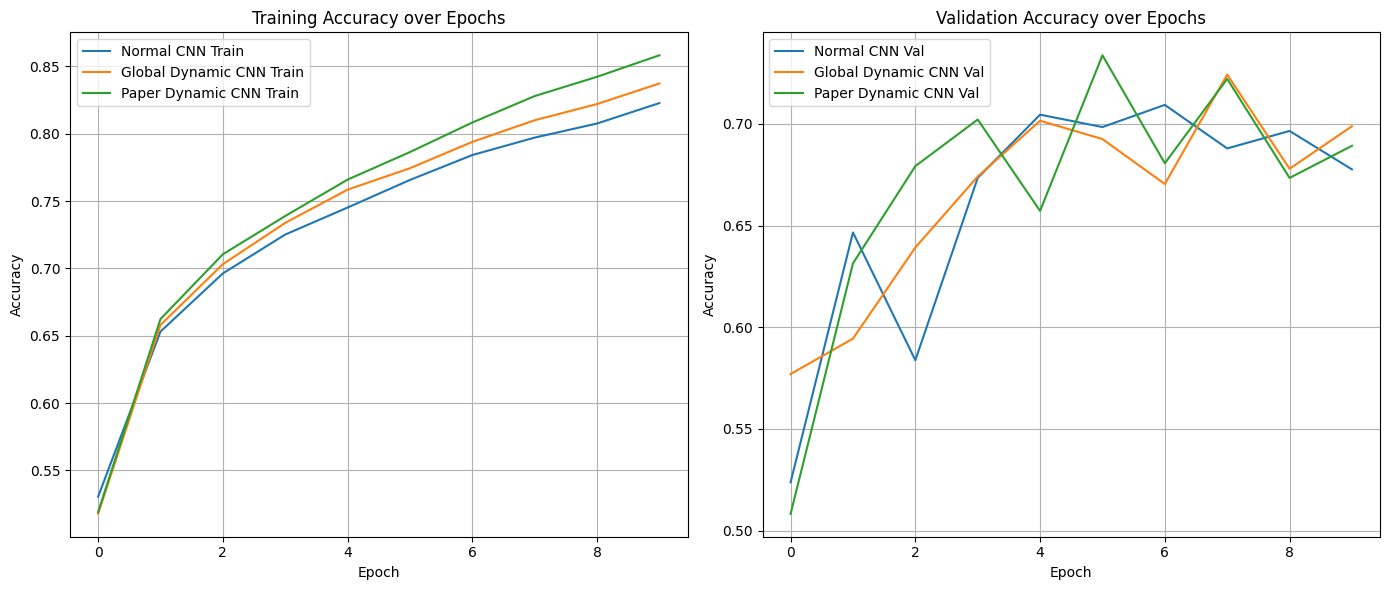

In [23]:
import matplotlib.pyplot as plt

# Step 11: Plot Training and Validation Accuracy
def plot_accuracies(histories, names):
    plt.figure(figsize=(14, 6))

    # Plot Training Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
    plt.title('Training Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Validation Accuracy
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_accuracies(
    [history_normal, history_dynamic, history_paper_dynamic],
    ["Normal CNN", "Global Dynamic CNN", "Paper Dynamic CNN"]
)
